# Market Basket Analysis based on Store Department

In [2]:
# Cell 1: Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import os
import warnings
warnings.filterwarnings("ignore")

# Create output folder if not exists
os.makedirs("../output", exist_ok=True)

# Original code
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from mlxtend.frequent_patterns import apriori, association_rules

In [3]:
# Cell 2: Load and preprocess data
df = pd.read_csv("../data/processed/cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Limit for memory optimization (original code used full dataset)
# df_market = df.copy()
df_market = df.sample(frac=0.25, random_state=42)  # ~25% of data

# Convert to basket format: one row per Date and Store
basket = df_market.groupby(['Date', 'Store', 'Dept'])['Weekly_Sales'].sum().unstack().fillna(0)

# Convert to binary
basket_binary = basket.applymap(lambda x: 1 if x > 0 else 0).astype(bool)  # ensure bool dtype

basket_binary.head()


Dept                 1      2      3      4      5      6      7      8   \
Date       Store                                                           
2010-02-05 1      False   True   True  False  False   True   True  False   
           2       True  False  False   True  False  False  False  False   
           3      False  False   True  False   True   True  False  False   
           4      False  False  False   True  False  False   True  False   
           5       True  False  False  False   True   True  False  False   

Dept                 9      10  ...     90     91     92     93     94     95  \
Date       Store                ...                                             
2010-02-05 1      False  False  ...  False   True  False  False  False  False   
           2      False  False  ...  False  False  False  False  False  False   
           3      False  False  ...  False  False  False  False  False   True   
           4      False   True  ...  False  False   True  False   True   True   
           5      False  False  ...  False  False  False  False  False  False   

Dept                 96     97     98     99  
Date       Store                              
2010-02-05 1      False  False  False  False  
           2      False   True  False  False  
           3      False  False  False  False  
           4      False  False  False  False  
           5       True  False  False  False  

[5 rows x 81 columns]

In [4]:
# Cell 3: Generate frequent itemsets
# Original: use_colnames=True
frequent_itemsets = apriori(basket_binary, 
                            min_support=0.02,  # low threshold for demo
                            use_colnames=True, 
                            low_memory=True, 
                            verbose=1)

frequent_itemsets.sort_values("support", ascending=False).head()

# Save frequent itemsets
frequent_itemsets.to_csv("../output/frequent_itemsets.csv", index=False)

Processing 112 combinations | Sampling itemset size 32


In [14]:
# Cell 4: Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values('confidence', ascending=False)

# Save rules
rules.to_csv("../output/association_rules.csv", index=False)
top_rules = rules[:10]

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3008,"(40, 25)",(59),0.059674,0.250971,0.020513,0.343750,1.369679,1.0,0.005536,1.141377,0.287030,0.070702,0.123865,0.212742
2913,"(16, 4)",(3),0.065579,0.253302,0.022067,0.336493,1.328424,1.0,0.005456,1.125380,0.264579,0.074346,0.111411,0.211805
2919,"(90, 4)",(3),0.060140,0.253302,0.020047,0.333333,1.315951,1.0,0.004813,1.120047,0.255456,0.068326,0.107180,0.206237
2980,"(5, 7)",(10),0.061849,0.254235,0.020513,0.331658,1.304536,1.0,0.004789,1.115844,0.248834,0.069401,0.103818,0.206171
2858,"(1, 2)",(9),0.063559,0.257032,0.020824,0.327628,1.274661,1.0,0.004487,1.104996,0.230102,0.069466,0.095020,0.204322


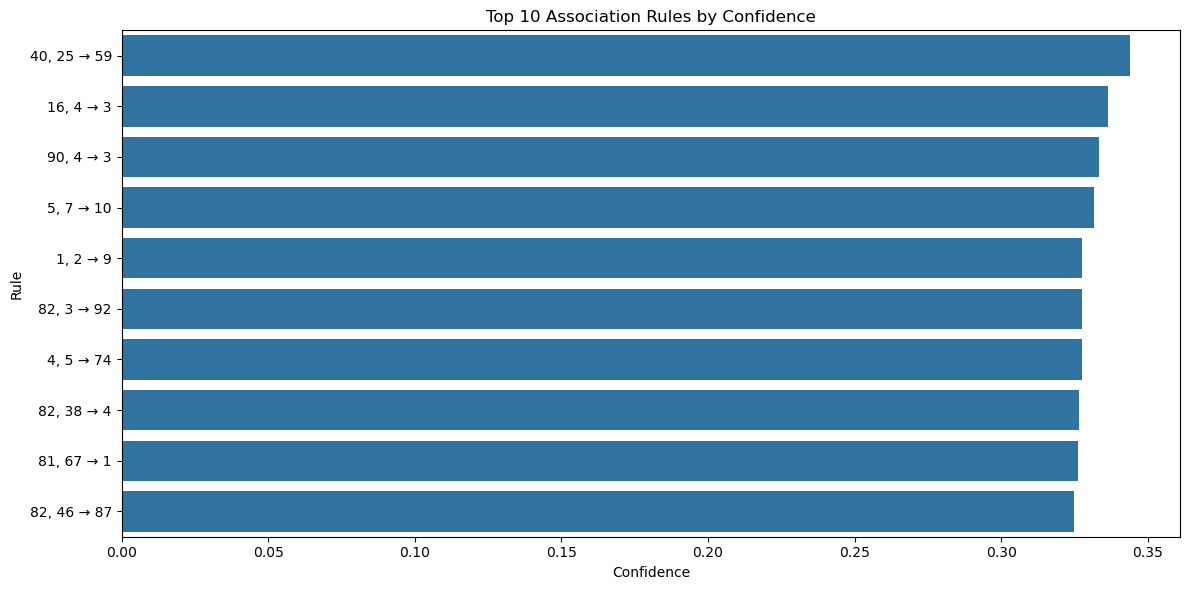

In [18]:
top_rules['rule'] = top_rules.apply(
    lambda row: f"{', '.join(str(i) for i in row['antecedents'])} → {', '.join(str(i) for i in row['consequents'])}", axis=1)

# Plot using rule label
plt.figure(figsize=(12, 6))
sns.barplot(x='confidence', y='rule', data=top_rules)
plt.title("Top 10 Association Rules by Confidence")
plt.xlabel("Confidence")
plt.ylabel("Rule")
plt.tight_layout()
plt.savefig("../output/top_association_rules.png")
plt.show()


This graph shows the top 10 Associativity rule according to its confidence (Max is 0.34 or around 34%)
An associativity rule among the department means if a customer buys from dept A and dept B, which next dept is he going to buy from
For eg: In the first rule, we can see that if a purchase is made from dept 40 and dept 25, there is a 34% chance that an item from dept 59 is going to be purchased too.

In [21]:
# Cell 6: Summary & Notes
print(f"Total transactions analyzed: {basket_binary.shape[0]}")
print(f"Frequent itemsets found: {len(frequent_itemsets)}")
print(f"Rules generated: {len(rules)}")

Total transactions analyzed: 6435
Frequent itemsets found: 2527
Rules generated: 3026


In [23]:
# Cell 7: Optional memory cleanup
del df, df_market, basket, basket_binary, frequent_itemsets, rules
import gc
gc.collect()

619929